## Imports

In [1]:
import numpy as np 
import matplotlib.pyplot as plt
import sys, os
sources_path = './../Sources/'
if sources_path not in sys.path:
    sys.path.append(sources_path)
from adaptive_filtering.lms import LMS

### Definitions

In [2]:
j = complex(0,1)
n_ensembles = 100   # number of realizations within the ensemble
K = 500             # number of iterations (signal length)
H = np.array([0.32+0.21*j,-0.3+0.7*j,0.5-0.8*j,0.2+1.5*j])
w_o = H            # Unknown system
sigma_n2 = .04     # noise power
N = 4              # Number of coefficients of the adaptive filter
mu = .1            # Convergence factor (step) (0 < mu < 1)

### Computing 

In [3]:
%%time
W = np.ones([n_ensembles, K+1, N], dtype=complex) # coefficient vector for each iteration and realization, w[0] = [1, 1, ..., 1]
MSE = np.zeros([n_ensembles, K]) # MSE vector for each realization
MSE_min = MSE # Minimum MSE for each realization 

for ensemble in np.arange(n_ensembles):
    X = np.zeros([N]) # input at a certain iteration (tapped delay line)
    d = np.array([]) # Desired signal
    
    # Creating the input signal (normalized)
    x = (np.sign(np.random.normal(size=K)) + j*np.sign(np.random.normal(size=K)))/np.sqrt(2) 
    sigma_x2 = np.var(x) # signal power = 1
    n = np.sqrt(sigma_n2/2)*(np.random.normal(size=K)+j*np.random.normal(size=K)) # complex noise
    
    for k in np.arange(K):
        X = np.append(x[k], X[1:N])
        d = np.append(d, np.dot(w_o, X)+n[k])
    
    init_coef = W[ensemble][1]
    filter_order = N-1    
    
    lms = LMS(step=mu, filter_order=filter_order, init_coef=init_coef)
    lms.fit(d, x)

    W[ensemble] = lms.coef_vector
    MSE[ensemble] = MSE[ensemble] + abs(lms.error_vector)**2
    MSE_min[ensemble] = MSE_min[ensemble] + abs(n)**2
    
W_av = sum(W, 3)/n_ensembles
MSE_av = sum(MSE, 2)/n_ensembles
MSEmin_av = sum(MSE_min, 2)/n_ensembles

print (lms)

LMS(step=0.1, filter_order=3)
Wall time: 1.34 s


### Plotting

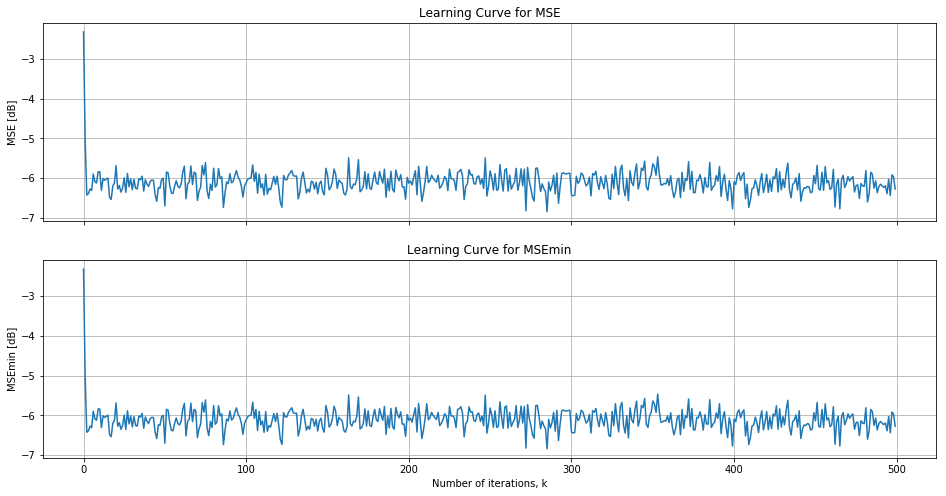

In [4]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(np.arange(K), 10*np.log10(MSE_av))
ax[0].set_title('Learning Curve for MSE')
ax[0].set_ylabel('MSE [dB]')
ax[0].grid(True)

ax[1].plot(np.arange(K), 10*np.log10(MSEmin_av))
ax[1].set_title('Learning Curve for MSEmin')
ax[1].set_ylabel('MSEmin [dB]')
ax[1].set_xlabel('Number of iterations, k') 
ax[1].grid(True)

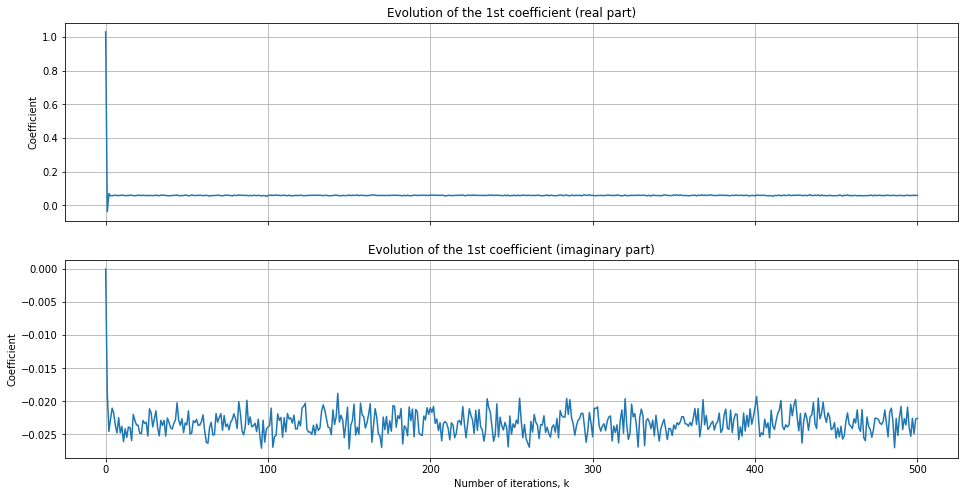

In [5]:
fig, ax = plt.subplots(ncols=1, nrows=2, figsize=(16,8), sharex=True)
ax[0].plot(np.arange(K+1), np.real(W_av[:,0]))
ax[0].set_title('Evolution of the 1st coefficient (real part)')
ax[0].set_ylabel('Coefficient')
ax[0].grid(True)

ax[1].plot(np.arange(K+1), np.imag(W_av[:,0]))
ax[1].set_title('Evolution of the 1st coefficient (imaginary part)')
ax[1].set_ylabel('Coefficient')
ax[1].set_xlabel('Number of iterations, k') 
ax[1].grid(True)